In [0]:

!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install sklearn



ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from google.colab import drive

Using TensorFlow backend.


In [0]:
df = pd.read_csv('/content/drive/My Drive/sample.csv',delimiter=',',encoding='latin-1')
df.head()

,Label,Category,Biller,Messages
0,Credit,Wallet,Paytm,Rs. 37 received from XXX (900018467 @paytm) i...
1,Credit,Wallet,Paytm,Rs. 766 received from XXX (900028145 @paytm) ...
2,Credit,Wallet,Paytm,Rs. 308 received from XXX (900014604 @paytm) ...
3,Credit,Wallet,Paytm,Rs. 365 received from XXX (900021726 @paytm) ...
4,Credit,Wallet,Paytm,Rs. 698 received from XXX (900023811 @paytm) ...


Text(0.5, 1.0, 'Number of credit and debit messages')

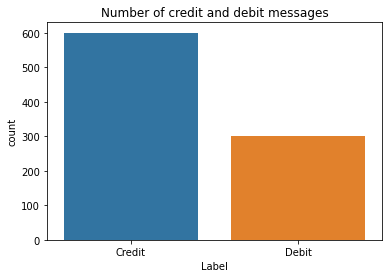

In [0]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of credit and debit messages')


In [0]:
df.drop(['Category', 'Biller'],axis=1,inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
Label       900 non-null object
Messages    900 non-null object
dtypes: object(2)
memory usage: 14.2+ KB


In [0]:
num_of_categories = 200
shuffled = df.reindex(np.random.permutation(df.index))
Credit = shuffled[shuffled['Label'] == 'Credit'][:num_of_categories]
Debit = shuffled[shuffled['Label'] == 'Debit'][:num_of_categories]
concated = pd.concat([Credit,Debit], ignore_index=True)

In [0]:
concated = concated.reindex(np.random.permutation(concated.index))

X = df.Messages
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [0]:
max_words = 3000
max_len = 110
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [0]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

model.fit(sequences_matrix,Y_train,batch_size=325,epochs=2, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 110)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 110, 50)           150000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,Y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.5f}'.format(accr[0],accr[1]))



135/135 [==============================] - 0s 2ms/step
Test set
  Loss: 0.588
  Accuracy: 1.00000


In [0]:
txt =["Rs. 37  received from XXX (900018467 @paytm) in your Paytm Payments Bank a/c 91XX8102. UPI Ref: 007322743179"]
seq = tok.texts_to_sequences(txt)
padded = sequence.pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred)
if(pred < 0.5):
  print("Credit")

else:
  print ("Debit")

[[0.43398824]]
Credit
